In [20]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket = 'mnistkmeans' # Use the name of your s3 bucket here

In [21]:
role

'arn:aws:iam::834811276895:role/service-role/AmazonSageMaker-ExecutionRole-20240504T215427'

In [22]:
%%time
import pickle, gzip, numpy, urllib.request, json
import os
with gzip.open('./mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

/home/ec2-user/SageMaker
['.sparkmagic', 'test.csv', 'bank_clean.csv', 'MNISTDemo.ipynb', '.ipynb_checkpoints', 'mnist.pkl.gz', 'lost+found', '.Trash-1000', 'train.csv', 'sage_note1.ipynb', 'sageTest.ipynb']
CPU times: user 681 ms, sys: 308 ms, total: 989 ms
Wall time: 1.46 s


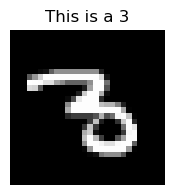

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

In [24]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_highlevel_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                epochs=100,
                data_location=data_location)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


training data will be uploaded to: s3://mnistkmeans/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://mnistkmeans/kmeans_highlevel_example/output


In [25]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-05-30-13-17-26-835


2024-05-30 13:17:27 Starting - Starting the training job...
2024-05-30 13:17:41 Starting - Preparing the instances for training...
2024-05-30 13:18:13 Downloading - Downloading input data...
2024-05-30 13:18:33 Downloading - Downloading the training image...
2024-05-30 13:19:18 Training - Training image download completed. Training in progress......Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/30/2024 13:20:04 INFO 140323930539840] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', 

In [26]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2024-05-30-13-22-08-787
INFO:sagemaker:Creating endpoint-config with name kmeans-2024-05-30-13-22-08-787
INFO:sagemaker:Creating endpoint with name kmeans-2024-05-30-13-22-08-787


-------!CPU times: user 99.6 ms, sys: 10 ms, total: 110 ms
Wall time: 4min 2s


In [27]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 44.5 ms, sys: 109 µs, total: 44.6 ms
Wall time: 244 ms





Cluster 0:


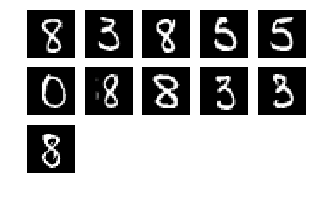




Cluster 1:


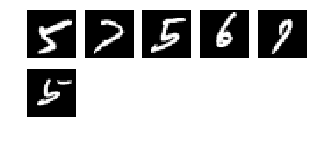




Cluster 2:


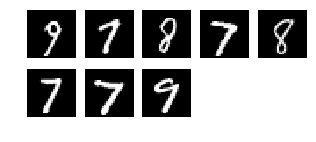




Cluster 3:


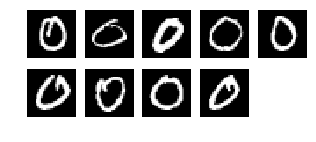




Cluster 4:


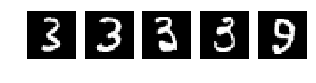




Cluster 5:


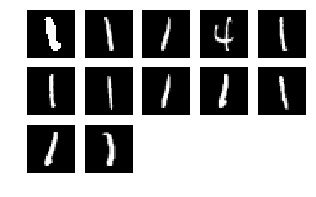




Cluster 6:


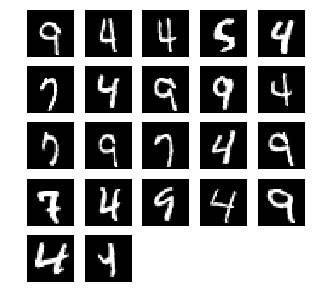




Cluster 7:


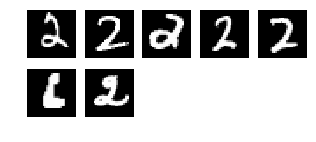




Cluster 8:


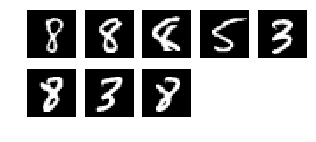




Cluster 9:


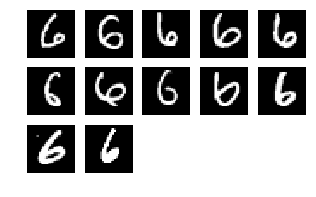

In [37]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height = ((len(digits)-1)//5) + 1
    width = 5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

In [28]:
result = kmeans_predictor.predict(valid_set[0][230:231])
print(result)

[label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 6.29484415
    }
  }
}
label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0
    }
  }
}
]


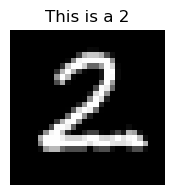

In [29]:
show_digit(valid_set[0][230], 'This is a {}'.format(valid_set[1][230]))